# Лабораторная работа 1. Классические методы построения рекомендаций.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shashist/recsys-course/blob/main/homeworks/hw_01/rs_hw01.ipynb)

В лабораторной вам нужно будет реализовать несколько метрик, применить  популярные модели и оценить влияние гиперпараметров на качество рекомендаций.

### Формат сдачи задания
Лаботаторная сдается в виде ipynb-файла. Каждое выполененное задание должно сопровожаться текстом с выводами. Добавьте визуализации результатов, например, в заданиях на сравнение качества при разных гиперпараметрах. Постарайтесь делать код лаконичным и понятным для проверяющих.

Фиксируйте random seed для воспроизводимости результатов.


### Оценивание
За лабораторную можно получить максимум 5 баллов. Предполагается, что вычислительных ресурсов google colab хватит для успешного выполнения работы.

### Общая информация о задаче
В лабораторной работе будет использоваться классический датасет [MovieLens 1M](https://paperswithcode.com/sota/collaborative-filtering-on-movielens-1m), содержащий оценки фильмов пользователями и признаки пользователей и фильмов.

Для всех заданий, связанных с генерацией рекомендаций, $K=20$, т.е. вам необходимо подготовить по 20 рекомендаций для каждого пользователя.

Так как датасет из области кино, и нам дана информация об оценках, необходимо выполнять фильтрацию просмотренных айтемов при генерации рекомендаций.

Мы будем разделять датасет на 2 части, train и validation, так как целью заданий является наглядная оценка влияния ключевых гиперпараметров (число соседей/латентных факторов) на качество. Если вы будете подбирать другие гиперпараметры моделей (коэффициенты регуляризации в als, коэффициенты K1 и B в bm25), отделите самостоятельно часть train для подбора параметров, а итоговое качество оценивайте после подбора параметров на validation. Подбор гиперпараметров можно реализовать, например, с помощью optuna.

Используйте последнюю версию библиотеки implicit. Пожалуйста, посмотрите [документацию](https://benfred.github.io/implicit/api/models/recommender_base.html) и примеры использования на [github](https://github.com/benfred/implicit), чтобы лучше разобраться с форматом входных данных.

Вопросы по заданию можно писать в чат курса. Ссылка на форму для отправки решений будет дана в чате.

In [291]:
!pip install optuna

In [292]:
!pip install implicit

In [293]:
!pip install rs-datasets

In [295]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix

import implicit
from implicit.als import AlternatingLeastSquares

from copy import deepcopy
from tqdm import tqdm

from implicit.nearest_neighbours import BM25Recommender
import optuna

In [296]:
K = 20
SEED = 123
np.random.seed(SEED)

## Знакомство с данными

    


## Задание 1

**(0.5 балла) Задание 1.** Знакомство с данными.
Проанализируйте, насколько активно пользователи оставляют оценки, насколько активно фильмы получают оценки, какие оценки преобладают, как меняется количество оценок во времени. Опишите свои результаты.

In [297]:
from rs_datasets import MovieLens

In [298]:
data = MovieLens("1m")
data.info()

ratings


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968



users


,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117



items


,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [299]:
def get_log_info(log, user_id='user_id', item_id='item_id'):
    print('Длина лога = {},\nколичество пользователей = {},\nколичество объектов = {}'
          .format(log.shape[0], log[user_id].nunique(), log[item_id].nunique()))

In [300]:
reviews = data.ratings
reviews.rename(columns={"rating": "relevance"}, inplace=True)
reviews['timestamp'] = pd.to_datetime(reviews['timestamp'], unit='s')
reviews.head(1)

,user_id,item_id,relevance,timestamp
0,1,1193,5,2000-12-31 22:12:40


In [301]:
get_log_info(reviews)

Длина лога = 1000209,
количество пользователей = 6040,
количество объектов = 3706


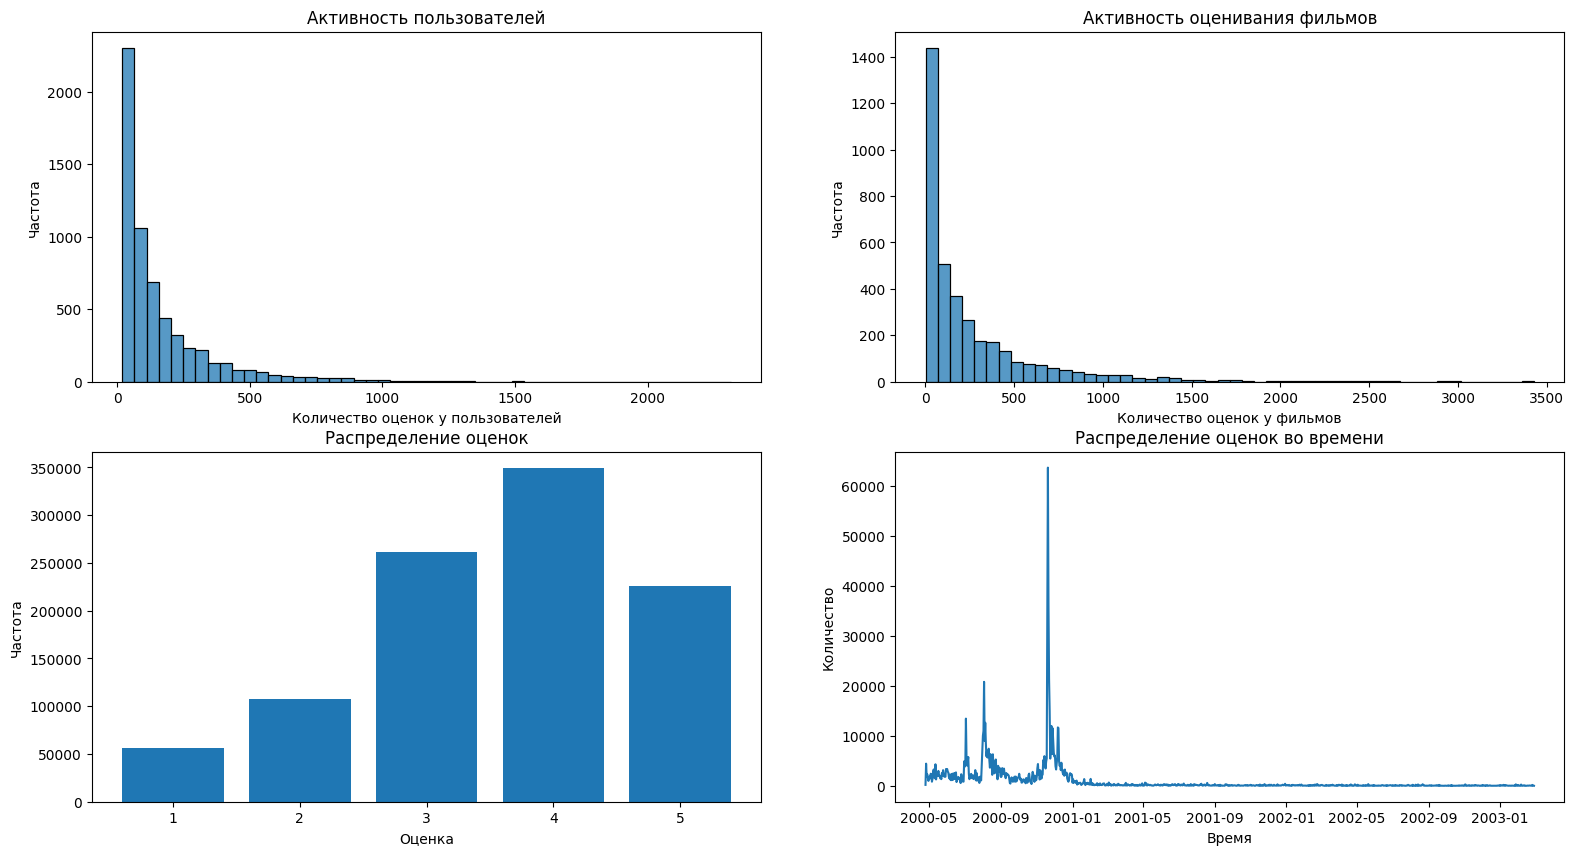

In [302]:
fig, axs = plt.subplots(2,2, figsize=(19,10))

ax = axs[0, 0]
sns.histplot(reviews.groupby('user_id').count()['item_id'], bins=50, ax=ax)
ax.set_title('Активность пользователей')
ax.set_xlabel('Количество оценок у пользователей')
ax.set_ylabel('Частота')

ax = axs[0, 1]
sns.histplot(reviews.groupby('item_id').count()['user_id'], bins=50, ax=ax)
ax.set_title('Активность оценивания фильмов')
ax.set_xlabel('Количество оценок у фильмов')
ax.set_ylabel('Частота')

ax = axs[1, 0]
ax.bar([1,2,3,4,5], reviews.groupby('relevance').count()['user_id'])
ax.set_title('Распределение оценок')
ax.set_xlabel('Оценка')
ax.set_ylabel('Частота')

ax = axs[1, 1]
reviews["date"] = reviews["timestamp"].dt.date
ax.plot(reviews.groupby("date").size().index, reviews.groupby("date").size().values)
ax.set_title('Распределение оценок во времени')
ax.set_xlabel('Время')
ax.set_ylabel('Количество')

plt.show()

Таким образом, по построенным графикам видно, что большинство пользователей ставят мало оценок на фильмы и существует множество фильмов, которые имеют всего несколько отзывов -- люди просто не хотят ставить оценки. При этом чаще всего фильмам ставят оценку 4, а реже всего -- 1. Видимо, мы работаем не с самой негативной аудиторией, но возможно для многих людей оценка 4 в этом контексте -- уже знак, что фильм не понравился. Во временной зависимости мы видим, что есть 3 пика, где много людей резко начали ставить оценки, что может быть связано просто с популярностью сервиса.

In [303]:
rpt = reviews[(reviews['date'] > pd.to_datetime('20000601').date()) & (reviews['date'] < pd.to_datetime('20010101').date())]

In [304]:
rpt.item_id.value_counts()[:15]

,count
item_id,
2858,3045
1196,2545
260,2534
1210,2480
480,2336
589,2307
2028,2297
1270,2218
1580,2207


item_id 2858 - Красота по Американски. Очень популрный фильм конца 1999 года.

In [305]:
rpt.user_id.value_counts()

,count
user_id,
4169,2029
1680,1850
889,1518
1181,1487
4277,1443
...,...
5487,1
5664,1
5668,1


Но в итоге по ощущению присутствие 3 пиков не связана с какими-то бурными новинками, а просто с популярностью самих отзывов как таковых.

In [306]:
reviews = reviews.drop('date', axis=1)

## Задание 2
**(0.5 балла) Задание 2.**
Фильтрация и разбиение данных

Будем использовать global time split, т.е. отделим train и validation по выбранной дате.

Реализуйте такое разбиение:

1) данные до 1 декабря 2000 года не включая - данные train

2) данные с 1 декабря 2000 года включительно до 31 декабря 2000 года включительно - валидационные данные.

В валидационных данных должны остаться только положительные оценки (хотим предсказать, что пользователю понравится). Будем считать положительными оценки > 3. Удалим из валидационной выборки холодных пользователей, так как большинство рассматриваемых алгоритмов не генерируют рекомендации для холодных.

In [307]:
train = reviews[reviews["timestamp"] < pd.to_datetime("20001201")]
val = reviews[(reviews["timestamp"] >= pd.to_datetime("20001201")) & (reviews["timestamp"] <= pd.to_datetime("20001231"))]
val = val[val['relevance'] > 3]
train_users = set(train["user_id"])
val = val[val["user_id"].isin(train_users)]

In [308]:
val.shape[0]

14790

In [309]:
assert train.shape[0] == 791270
assert val.shape[0] == 14790

In [310]:
get_log_info(train)

Длина лога = 791270,
количество пользователей = 5365,
количество объектов = 3662


In [311]:
get_log_info(val)

Длина лога = 14790,
количество пользователей = 522,
количество объектов = 2341


In [312]:
train['relevance'] = train['relevance'].astype(float)

<ipython-input-312-d0ac5a6645a4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['relevance'] = train['relevance'].astype(float)


## Задание 3
**(0.5 балла) Задание 3.** Базовое решение.

Порекомендуем для каждого пользователя из val 20 случайных фильмов. Датасет с рекомендациями должен содержать колонки  user_id, item_id, relevance.

In [313]:
%%time
np.random.seed(SEED)

unique_users = val["user_id"].unique()
unique_items = set(reviews["item_id"].unique())
watched_items_by_user = train.groupby("user_id")["item_id"].apply(set).to_dict()
recommendations = []

for user in unique_users:
    watched_items = watched_items_by_user.get(user, set())
    candidate_items = list(unique_items - watched_items)

    if len(candidate_items) < 20:
        print('Недостаточный выбор фильмов')
        sampled_items = candidate_items
    else:
        sampled_items = np.random.choice(candidate_items, 20, replace=False)

    for item in sampled_items:
        recommendations.append((user, item, np.random.choice([1, 2, 3, 4, 5])))

random_pred = pd.DataFrame(recommendations, columns=["user_id", "item_id", "relevance"])

CPU times: user 1.25 s, sys: 21 ms, total: 1.27 s
Wall time: 2.05 s


In [314]:
assert random_pred.shape[0] == val['user_id'].nunique() * K

In [315]:
random_pred.head(1)

,user_id,item_id,relevance
0,670,1394,4


## Задание 4
**(1.25 балл) Задание 4.** Метрики качества.


Используйте следующий набор метрик качества:
- NDCG@K (необходимо реализовать) **(0.5 балла)**
- HitRate@K (можно взять с семинара или использовать готовую реализацию)
- Coverage@K (можно взять с семинара или использовать готовую реализацию)
- Surprisal@K (необходимо реализовать) **(0.5 балла)**

1) Реализуйте метрики NDCG@K, Surprisal@K **(1 балл)**

2) **(0.25 балла)** Создайте функцию, которая генерирует словарь/dataframe с 4 метриками по предоставленному решению. Оцените baseline-решение на валидации


Не забудьте, что мы можем считать метрику для разных значений k (например, изначально подготовили 10 рекомендаций, а считаем метрику для k = 1, 5, 10). В этом случае при подсчете метрики используются первые top-k рекомендаций и все релевантные айтемы из ground truth.

Будем использовать следующие обозначения в формулах:

$i$ – идентификатор пользователя, целое число от 1 до N

$j$ – позиция товара в списке рекомендаций для пользователя $i$, целое число от 1 до K

$N$ – количество пользователей

$K$ – количество айтемов в списке рекомендаций, для которого рассчитывается метрика

$\mathbb{1}_{r_{ij}}$ - индикаторная функция, факт приобретения пользователем i продукта на позиции j  в списке рекомендаций

$|Rel_i|$ - количество айтемов, с которыми были положительные взаимодействия у пользователя $i$ в тестовом периоде


### NDCG

Реализуйте бинарную версию метрики NDCG (Normalized Discounted Cumulative Gain) для оценки качества ранжирования. В банирной версии фактические значения релевантности в ground truth игнорируются, используется только инофрация о факте положительного взаимодействия.

1) Посчитаем DCG

$$DCG@K(i) = \sum_{j=1}^{K}\frac{\mathbb{1}_{r_{ij}}}{\log_2 (j+1)}$$

2) Чтобы получить Normalized метрику, вычислим максимально возможное для данного пользователя значение $DCG@K$, $IDCG@K$.

$$IDCG@K(i) = max(DCG@K(i)) = \sum_{j=1}^{K}\frac{\mathbb{1}_{j\le|Rel_i|}}{\log_2 (j+1)}$$

$$nDCG@K(i) = \frac{DCG@K(i)}{IDCG@K(i)}$$

3) Результат усредним по пользователям.

$$ nDCG@K = \frac{\sum_{i=1}^{N}nDCG@K(i)}{N}$$
    


#### NDCG для одного пользователя

In [316]:
import math

In [317]:
def ndcg_user(row, k):
    """
    row: row of pd.Dataframe with columns `pred_list`, `gt_list`
    """
    DCG = np.sum(np.isin(row.pred_list[:k], row.gt_list) / np.log2(np.arange(min(len(row.pred_list), k)) + 2))
    IDCG = np.sum(1 / np.log2(np.arange(min(len(row.gt_list), k)) + 2))
    return DCG / IDCG if IDCG != 0 else 0


In [318]:
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]}), k=3), 0.296, abs_tol=1e-3)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]}), k=5), 0.246, abs_tol=1e-3)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 2, 3], 'gt_list': [4, 5, 2, 6]}), k=1), 0., abs_tol=1e-3)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [], 'gt_list': [4, 5, 2, 6]}), k=10), 0)
assert math.isclose(ndcg_user(pd.Series({'user_id': 1, 'pred_list': [1, 3], 'gt_list': []}), k=10), 0)

In [319]:
ngcg = 0
for user_id in random_pred['user_id'].unique():
    pred_list = random_pred[random_pred['user_id'] == user_id].item_id.to_list()
    gt_list = val[val['user_id'] == user_id].item_id.to_list()
    ngcg_oneuser = ndcg_user(pd.Series({'user_id': user_id, 'pred_list': pred_list, 'gt_list': gt_list}), k=20)
    ngcg += ngcg_oneuser
all_ngcg = ngcg / len(random_pred['user_id'].unique())

In [320]:
print(all_ngcg)

0.008849688328830123


### Surprisal
Посмотрим, насколько наши рекомендации хороши с точки зрения новизны для пользователя. В качестве новизны будем рассматривать "непопулярность" айтемов в рекомендациях.

1. Будем рассматривать собственную информацию item-а как меру его новизны для пользователей.

    $$selfInformation(i) = -\log_2 \frac{|u_i|}{N}, $$
    где $i$ - объект (item), $N$ - число пользователей в обучающей выборке, $|u_i|$ - число пользователей, взаимодействовавших с объектом $i$ в обучающей выборке.


2. Собственная информация определяется для item-а, а значение метрики мы хотим считать для пользователя и $k$ - количества рекомендаций. Для подсчета Surprisal пользователя усредним значения собственной информации в топ-k рекомендациях этого пользователя.

    Чтобы получить значения от 0 до 1, разделим значение метрики для пользователя на максимально возможно значение метрики равное $log_2 N$.

$$Surprisal(u, k) = \frac{1}{k log_2 N} \sum_{i}^{k}selfInformation(i)$$


3. Результат усредним по пользователям.

Что делать с холодными item-ами при подсчете $selfInformation$? Максимально простой вариант — считать, что для них было взаимодействие с одним пользователем.

Обратите внимание, что self information можно расчитать один раз при инициализации метрики. Возможно, эту метрику стоит сделать классом.

In [321]:
class Surprisal:
    def __init__(self, log: pd.DataFrame):
        total_users = log['user_id'].nunique()
        self.information = dict(-np.log2(log.groupby("item_id").count().user_id / total_users))
        self.default_value = np.log2(total_users)

    def __call__(self, pred, k):
        surprisal = 0
        n_users_pred = pred.user_id.nunique()

        for user_id in pred.user_id.unique():
            for item_id in pred[pred.user_id == user_id].item_id[:k]:
                surprisal += self.information.get(item_id, self.default_value)

        return surprisal / (n_users_pred * k * self.default_value)

In [322]:
surp = Surprisal(pd.DataFrame({'user_id': [1, 2, 3, 3], 'item_id': [1, 2, 2, 3], 'relevance': [0.5, 0.1, 1., 0.1]}))
assert math.isclose(surp(pd.DataFrame({'user_id': [1], 'item_id': [4], 'relevance': [0.5]}), k=1), 1)
assert math.isclose(surp(pd.DataFrame({'user_id': [1], 'item_id': [4], 'relevance': [0.5]}), k=2), 0.5)
assert math.isclose(surp(pd.DataFrame({'user_id': [2, 2], 'item_id': [3, 2], 'relevance': [0.1, 1]}), k=2), 0.685, abs_tol=1e-3)
assert math.isclose(surp(pd.DataFrame({'user_id': [1, 2, 2], 'item_id': [4, 3, 2], 'relevance': [0.5, 0.1, 1]}), k=2), (0.684 + 0.5) / 2, abs_tol=1e-3)

In [323]:
def coverage(pred, k, all_items=train['item_id']):
    pred_to_consider = set(leave_top_k(pred, k)['item_id'].values)
    all_items = set(all_items.values)
    return len(pred_to_consider & all_items) / len(all_items)


def user_hr(row):
    """
    Calculate HitRate value.

    'row' contains
        a list of ground truth items in ``gt_items`` and
        a list of recommended items in ``pred_list``.
    """
    for item in row['pred_list']:
        if item in row['gt_list']:
            return 1
    return 0

In [324]:
def metric_wrap(pred, ground_truth, k, metric_by_user):
    """
    Prepare data for metric calculation (create dataframe with columns 'user_id', 'pred_list', 'gt_list').

    'pred_list' is a list of top-k recommendation ordered by relevance (most relevant is the first)
    'gt_list' is a list of items from tests data.
    Return mean metric value and dataframe with metric value for each user
    """
    pred_cropped = leave_top_k(pred, k)
    # prepare score lists
    pred_grouped = (pred_cropped
                .sort_values(['user_id', 'relevance'], ascending=[False, False])
                .groupby('user_id')['item_id']
                .apply(list).rename('pred_list')
               )
    gt_grouped = ground_truth.groupby('user_id')['item_id'].apply(list).rename('gt_list')
    to_compare = gt_grouped.to_frame().join(pred_grouped, how='left')
    to_compare['pred_list'] = to_compare['pred_list'].apply(lambda x: x if isinstance(x, list) else [])
    # compute metric
    metric_by_user = to_compare.apply(metric_by_user, axis=1)
    return metric_by_user.mean(), metric_by_user



def leave_top_k(pred: pd.DataFrame,
                 k: int=K,
                 group_by_col: str='user_id',
                 order_by_col: str='relevance') -> pd.DataFrame:
    """
    crop predictions to leave top-k recommendations for each user
    """
    if pred.groupby(group_by_col)[group_by_col].count().max() <= k:
        return pred
    cropped_pred = deepcopy(pred)
    cropped_pred['rank'] = (cropped_pred
                            .groupby(group_by_col)[[order_by_col]]
                            .rank(method="first", ascending=False))
    cropped_pred = cropped_pred[cropped_pred['rank'] <= k].drop(columns=['rank'])
    return cropped_pred

In [325]:
def measure(pred, true, train, k, name, df=None):
    if df is None:
        df = pd.DataFrame(columns=['hit_rate@K', 'coverage@K', 'Surprisal', 'nDCG@K'])
    df.loc[name, 'hit_rate@K'] = metric_wrap(pred=pred, ground_truth=true, k=K, metric_by_user=user_hr)[0]
    df.loc[name, 'coverage@K'] = coverage(pred=pred, k=k)
    df.loc[name, 'Surprisal'] = Surprisal(train)(pred, k)
    ngcg = 0
    for user_id in pred['user_id'].unique():
        pred_list = pred[pred['user_id'] == user_id].item_id.to_list()
        gt_list = true[true['user_id'] == user_id].item_id.to_list()
        ngcg_oneuser = ndcg_user(pd.Series({'user_id': user_id, 'pred_list': pred_list, 'gt_list': gt_list}), k=k)
        ngcg += ngcg_oneuser
    all_ngcg = ngcg / len(pred['user_id'].unique())
    df.loc[name, 'nDCG@K'] = all_ngcg
    return df

In [326]:
rec_data = measure(random_pred, val, train, 20, 'Baseline')
rec_data

,hit_rate@K,coverage@K,Surprisal,nDCG@K
Baseline,0.124521,0.931731,0.519658,0.00885


Как можно увидеть, случайное предсказание рекомендует не очень качественно, но очень разнообразно. Но для хорошего сервиса, конечно, такой метод не подойдет.

## Задание 5
**(1.25 балла) Задание 5.** item-based knn

1) **(0.5 балла)** Примените [CosineRecommender](https://benfred.github.io/implicit/api/models/cpu/knn.html) из библиотеки [implicit](https://github.com/benfred/implicit). Оцените влияние количества соседей (параметр K) на качество рекомендаций (по 4 реализованным метрикам). Постройте график зависимости NDCG@20 от числа соседей.

2) **(0.5 балла)** Разберитесь, в чем состоит идея использования весов tfidf и bm25, например, по [этой статье](https://www.benfrederickson.com/distance-metrics/). Выберите один из способов (tfidf или bm25) взвешивания, опишите текстом основную идею. Примените выбранную модель, подберите гиперпараметры на отложенных данных (разбейте самостоятельно) и оцените качество на val-датасете.

3) **(0.25 балла)** Повторите эксперимент, используя для обучения только положительные оценки (> 3). Не забудьте при фильтрации просмотренных учесть все взаимодействия (не только положительные). Как это повлияло на качество?

Удалось ли достичь лучшего качества, чем с использованием Cosine?

Во всех заданиях дальше наш код будет состоять из двух частей -- предобработка данных для корректного и быстрого обучени модели и самого обучени. Саму предобработку запишем в отдельную функцию.

In [327]:
def preproc(train, val):
    user_cat = train['user_id'].astype('category')
    item_cat = train['item_id'].astype('category')
    user_ids = user_cat.cat.codes
    item_ids = item_cat.cat.codes
    user_item_matrix = csr_matrix((train['relevance'], (user_ids, item_ids)))
    val_users = val['user_id'].unique()
    user_mapping = dict(zip(user_cat.cat.categories, range(len(user_cat.cat.categories))))
    item_mapping = dict(zip(range(len(item_cat.cat.categories)), item_cat.cat.categories))
    item_mapping_rev = dict(zip(item_cat.cat.categories, range(len(item_cat.cat.categories))))
    return (user_item_matrix, val_users, user_mapping, item_mapping, item_mapping_rev)

### CosineRecommender

Для начала разберемся с CosineRecommender -- построим график зависимости метрик от парметра K.

In [328]:
user_item_matrix, val_users, user_mapping, item_mapping, _ = preproc(train, val)

In [329]:
Ks = np.concat([np.array([10, 15, 20, 25, 30]), np.arange(30, 600, 40)])
metrics = {'hit_rate@K': [], 'coverage@K': [], 'Surprisal': [], 'nDCG@K': []}
for K in Ks:
    model = implicit.nearest_neighbours.CosineRecommender(K=K)
    model.fit(user_item_matrix)
    recommendations = []
    for user in tqdm(val_users):
        user_idx = user_mapping[user]
        recs = model.recommend(user_idx, user_item_matrix[user_idx], N=20, filter_already_liked_items=True)

        for item_idx, relevance in zip(recs[0], recs[1]):
            recommendations.append((user, item_mapping[item_idx], relevance))
    recommendations = pd.DataFrame(recommendations, columns=['user_id', 'item_id', 'relevance'])
    metrics_res = measure(recommendations, val, train, 20, 'CosineRecommender')
    for i, key in enumerate(metrics.keys()):
        metrics[key].append(np.array(metrics_res)[0][i])

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0055544376373291016 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 7218.02it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005441188812255859 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 5514.97it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005306720733642578 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 6545.59it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005859375 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 4064.23it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006084918975830078 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 6315.27it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005413055419921875 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 5654.88it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005428314208984375 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 4652.40it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.00569605827331543 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 3717.15it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0058825016021728516 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 2835.93it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005483388900756836 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 1937.11it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005982875823974609 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 1069.08it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.007089138031005859 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 820.80it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.017247915267944336 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 653.52it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005761384963989258 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 626.66it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.022114038467407227 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 784.87it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006121158599853516 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 667.98it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.016117334365844727 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 1692.81it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005506038665771484 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 1540.35it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.00542759895324707 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 1491.30it/s]
/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.00544428825378418 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 855.38it/s]


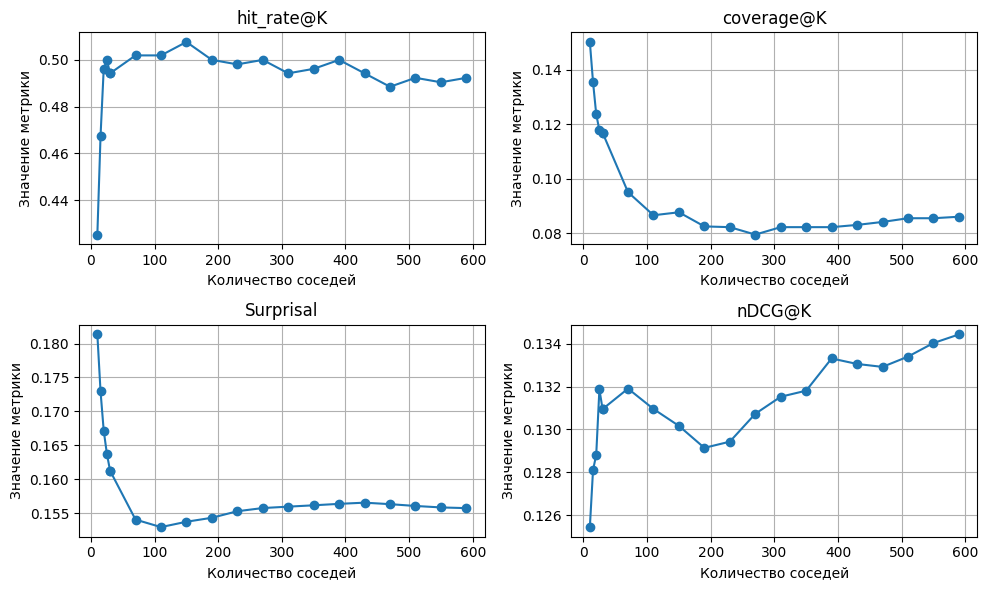

In [330]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()
for ax, (key, values) in zip(axes, metrics.items()):
    ax.plot(Ks, values, marker='o')
    ax.set_xlabel("Количество соседей")
    ax.set_ylabel("Значение метрики")
    ax.set_title(key)
    ax.grid()
plt.tight_layout()
plt.show()

In [331]:
max_K_cos = np.argmax(metrics['nDCG@K'])
cos_metrics = {'hit_rate@K' : metrics['hit_rate@K'][max_K_cos],
               'coverage@K' : metrics['coverage@K'][max_K_cos],
               'Surprisal' : metrics['Surprisal'][max_K_cos],
               'nDCG@K' : metrics['nDCG@K'][max_K_cos]}
rec_data.loc["CosineRecommender"] = cos_metrics
rec_data

,hit_rate@K,coverage@K,Surprisal,nDCG@K
Baseline,0.124521,0.931731,0.519658,0.00885
CosineRecommender,0.492337,0.086019,0.155762,0.134443


Проанализируем полученные результаты.

С увеличением количества соседей метрики Coverage и Surprisal падают. Модель запоминает все больше соседей и диапазон подходящий для рекомендаций фильмов сужается. Метрика nDCG растет - чем больше соседей запомнила модель, тем более похожие предсказания она сделает. Метрика HitRate растет, потому что растет вариация выбора модели.

### TF-IDF

Рассматривае каждый фильма как документ, а каждого пользователя - как термин в этих документах. Идея TF-IDF: TF - частота item в данных, а IDF - логарифм обратной частоты. Таким образом, мы учитываем активных пользователей сильнее, а неизбирательных пользователей меньше.

In [332]:
train_tfidf = reviews[reviews["timestamp"] < pd.to_datetime("20001122")]
val_tfidf = reviews[(reviews["timestamp"] >= pd.to_datetime("20001122")) & (reviews["timestamp"] < pd.to_datetime("20001201"))]
val_tfidf = val_tfidf[val_tfidf['relevance'] > 3]
train_users_tfidf = set(train_tfidf["user_id"])
val_tfidf = val_tfidf[val_tfidf["user_id"].isin(train_users_tfidf)]
train_tfidf['relevance'] = train_tfidf['relevance'].astype(float)
user_item_matrix_tfidf, val_users_tfidf, user_mapping_tfidf, item_mapping_tfidf, _ = preproc(train_tfidf, val_tfidf)


def optimizing(trial):
    K = trial.suggest_int("K", 1, 500)

    metrics = {'hit_rate@K': [], 'coverage@K': [], 'Surprisal': [], 'nDCG@K': []}
    model = implicit.nearest_neighbours.TFIDFRecommender(K=K)
    model.fit(user_item_matrix_tfidf)
    recommendations = []
    for user in tqdm(val_users_tfidf):
        user_idx = user_mapping_tfidf[user]
        recs = model.recommend(user_idx, user_item_matrix_tfidf[user_idx], N=20, filter_already_liked_items=True)

        for item_idx, relevance in zip(recs[0], recs[1]):
            recommendations.append((user, item_mapping_tfidf[item_idx], relevance))
    recommendations = pd.DataFrame(recommendations, columns=['user_id', 'item_id', 'relevance'])
    metrics_res = measure(recommendations, val_tfidf, train_tfidf, 20, 'TF-IDF')
    for i, key in enumerate(metrics.keys()):
        metrics[key].append(np.array(metrics_res)[0][i])
    return metrics['nDCG@K']

study = optuna.create_study(direction="maximize")
study.optimize(optimizing, n_trials=20, show_progress_bar=True)

<ipython-input-332-53ec0ad8ce77>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_tfidf['relevance'] = train_tfidf['relevance'].astype(float)
[I 2025-03-24 20:47:13,971] A new study created in memory with name: no-name-3314c829-71a4-4dd1-8a7b-858a8f902cee


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.009261608123779297 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]



  0%|          | 0/367 [00:00<?, ?it/s]

100%|██████████| 367/367 [00:00<00:00, 2518.08it/s]


[I 2025-03-24 20:47:16,451] Trial 0 finished with value: 0.15677354582468736 and parameters: {'K': 319}. Best is trial 0 with value: 0.15677354582468736.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005093097686767578 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 1143.16it/s]


[I 2025-03-24 20:47:19,891] Trial 1 finished with value: 0.15607447065856522 and parameters: {'K': 286}. Best is trial 0 with value: 0.15677354582468736.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005076885223388672 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3197.30it/s]


[I 2025-03-24 20:47:22,111] Trial 2 finished with value: 0.13724407404943895 and parameters: {'K': 28}. Best is trial 0 with value: 0.15677354582468736.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.00482940673828125 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2465.98it/s]


[I 2025-03-24 20:47:24,191] Trial 3 finished with value: 0.1574667465283115 and parameters: {'K': 339}. Best is trial 3 with value: 0.1574667465283115.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005300283432006836 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 1521.25it/s]


[I 2025-03-24 20:47:27,274] Trial 4 finished with value: 0.15750929158473098 and parameters: {'K': 347}. Best is trial 4 with value: 0.15750929158473098.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.004771709442138672 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 1730.49it/s]


[I 2025-03-24 20:47:29,426] Trial 5 finished with value: 0.156833395661913 and parameters: {'K': 470}. Best is trial 4 with value: 0.15750929158473098.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.004599571228027344 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2099.30it/s]


[I 2025-03-24 20:47:31,422] Trial 6 finished with value: 0.15720999489437587 and parameters: {'K': 297}. Best is trial 4 with value: 0.15750929158473098.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0047779083251953125 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2069.89it/s]


[I 2025-03-24 20:47:33,407] Trial 7 finished with value: 0.156460862847816 and parameters: {'K': 309}. Best is trial 4 with value: 0.15750929158473098.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.004689693450927734 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2024.13it/s]


[I 2025-03-24 20:47:35,483] Trial 8 finished with value: 0.15682941138860165 and parameters: {'K': 446}. Best is trial 4 with value: 0.15750929158473098.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.00470280647277832 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2052.74it/s]


[I 2025-03-24 20:47:37,658] Trial 9 finished with value: 0.1567613994241053 and parameters: {'K': 422}. Best is trial 4 with value: 0.15750929158473098.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005851268768310547 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2183.81it/s]


[I 2025-03-24 20:47:40,379] Trial 10 finished with value: 0.15298482120586898 and parameters: {'K': 184}. Best is trial 4 with value: 0.15750929158473098.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.004893064498901367 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2768.23it/s]


[I 2025-03-24 20:47:42,243] Trial 11 finished with value: 0.1522754951094535 and parameters: {'K': 199}. Best is trial 4 with value: 0.15750929158473098.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.004844188690185547 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2024.58it/s]


[I 2025-03-24 20:47:44,248] Trial 12 finished with value: 0.1576560289629146 and parameters: {'K': 372}. Best is trial 12 with value: 0.1576560289629146.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.004767656326293945 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 1688.81it/s]


[I 2025-03-24 20:47:46,373] Trial 13 finished with value: 0.15788803541398908 and parameters: {'K': 395}. Best is trial 13 with value: 0.15788803541398908.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.004757881164550781 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 1955.76it/s]


[I 2025-03-24 20:47:48,480] Trial 14 finished with value: 0.15764239996555682 and parameters: {'K': 394}. Best is trial 13 with value: 0.15788803541398908.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.004709720611572266 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2126.19it/s]


[I 2025-03-24 20:47:50,409] Trial 15 finished with value: 0.1521180448192752 and parameters: {'K': 217}. Best is trial 13 with value: 0.15788803541398908.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.005068540573120117 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2645.38it/s]


[I 2025-03-24 20:47:53,049] Trial 16 finished with value: 0.1503244848921292 and parameters: {'K': 123}. Best is trial 13 with value: 0.15788803541398908.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0058171749114990234 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 1978.83it/s]


[I 2025-03-24 20:47:55,373] Trial 17 finished with value: 0.1577486298374653 and parameters: {'K': 386}. Best is trial 13 with value: 0.15788803541398908.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.004670143127441406 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2024.47it/s]


[I 2025-03-24 20:47:57,547] Trial 18 finished with value: 0.1570102034357581 and parameters: {'K': 458}. Best is trial 13 with value: 0.15788803541398908.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.004662752151489258 seconds
  warnings.warn(


  0%|          | 0/3633 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2018.09it/s]


[I 2025-03-24 20:47:59,726] Trial 19 finished with value: 0.15645649750733065 and parameters: {'K': 491}. Best is trial 13 with value: 0.15788803541398908.


In [333]:
study.best_params

{'K': 395}

In [334]:
K = study.best_params['K']
metrics = {'hit_rate@K': [], 'coverage@K': [], 'Surprisal': [], 'nDCG@K': []}
model = implicit.nearest_neighbours.TFIDFRecommender(K=K)
model.fit(user_item_matrix)
recommendations = []
for user in tqdm(val_users):
    user_idx = user_mapping[user]
    recs = model.recommend(user_idx, user_item_matrix[user_idx], N=20, filter_already_liked_items=True)

    for item_idx, relevance in zip(recs[0], recs[1]):
        recommendations.append((user, item_mapping[item_idx], relevance))
recommendations = pd.DataFrame(recommendations, columns=['user_id', 'item_id', 'relevance'])
metrics_res = measure(recommendations, val, train, 20, 'TF-IDF')
for i, key in enumerate(metrics.keys()):
    metrics[key].append(np.array(metrics_res)[0][i])

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0052034854888916016 seconds
  warnings.warn(


  0%|          | 0/3662 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 2040.20it/s]


In [335]:
IFIDF_metrics = {'hit_rate@K' : metrics['hit_rate@K'][0],
               'coverage@K' : metrics['coverage@K'][0],
               'Surprisal' : metrics['Surprisal'][0],
               'nDCG@K' : metrics['nDCG@K'][0]}
rec_data.loc["TF-IDF"] = IFIDF_metrics
rec_data

,hit_rate@K,coverage@K,Surprisal,nDCG@K
Baseline,0.124521,0.931731,0.519658,0.00885
CosineRecommender,0.492337,0.086019,0.155762,0.134443
TF-IDF,0.509579,0.090661,0.152611,0.133444


### TF-IDF on positive

Далее отделим все положительные метки в train.

In [337]:
train_tfidf = reviews[reviews["timestamp"] < pd.to_datetime("20001122")]
val_tfidf = reviews[(reviews["timestamp"] >= pd.to_datetime("20001122")) & (reviews["timestamp"] < pd.to_datetime("20001201"))]
val_tfidf = val_tfidf[val_tfidf['relevance'] > 3]
train_users_tfidf = set(train_tfidf["user_id"])
val_tfidf = val_tfidf[val_tfidf["user_id"].isin(train_users_tfidf)]
train_tfidf['relevance'] = train_tfidf['relevance'].astype(float)
train_positive = train_tfidf[train_tfidf['relevance'] > 3]
train_users_positive = set(train_positive["user_id"])
val_tfidf = val_tfidf[val_tfidf["user_id"].isin(train_users_positive)]

user_item_matrix_positive, val_users_tfidf, user_mapping_tfidf, item_mapping_tfidf, item_mapping_rev_tfidf = preproc(train_positive, val_tfidf)

def optimizing(trial):
    K = trial.suggest_int("K", 1, 500)

    metrics = {'hit_rate@K': [], 'coverage@K': [], 'Surprisal': [], 'nDCG@K': []}
    model = implicit.nearest_neighbours.TFIDFRecommender(K=K)
    model.fit(user_item_matrix_positive)
    recommendations = []
    for user in tqdm(val_users_tfidf):
        user_idx = user_mapping_tfidf[user]

        user_interactions = train_tfidf[train_tfidf['user_id'] == user]
        user_interactions = user_interactions[user_interactions['item_id'].isin(train_positive['item_id'])]
        seen_items = list(user_interactions['item_id'].map(item_mapping_rev_tfidf).values)

        recs = model.recommend(user_idx, user_item_matrix_positive[user_idx], N=20, filter_items=seen_items)

        for item_idx, relevance in zip(recs[0], recs[1]):
            recommendations.append((user, item_mapping_tfidf[item_idx], relevance))
    recommendations = pd.DataFrame(recommendations, columns=['user_id', 'item_id', 'relevance'])
    metrics_res = measure(recommendations, val_tfidf, train_positive, 20, 'TF-IDF on positive')
    for i, key in enumerate(metrics.keys()):
        metrics[key].append(np.array(metrics_res)[0][i])
    return metrics['nDCG@K']

study = optuna.create_study(direction="maximize")
study.optimize(optimizing, n_trials=20, show_progress_bar=True)

<ipython-input-337-2d3dd8fafe9e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_tfidf['relevance'] = train_tfidf['relevance'].astype(float)
[I 2025-03-24 20:49:19,223] A new study created in memory with name: no-name-7d9b2c46-876b-4451-901b-955009509a2b


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.003158092498779297 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 144.33it/s]


[I 2025-03-24 20:49:23,267] Trial 0 finished with value: 0.1808906717113571 and parameters: {'K': 224}. Best is trial 0 with value: 0.1808906717113571.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0026175975799560547 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 126.22it/s]


[I 2025-03-24 20:49:28,136] Trial 1 finished with value: 0.17979427801259315 and parameters: {'K': 344}. Best is trial 0 with value: 0.1808906717113571.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0032939910888671875 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 138.88it/s]


[I 2025-03-24 20:49:32,131] Trial 2 finished with value: 0.17061251894332496 and parameters: {'K': 29}. Best is trial 0 with value: 0.1808906717113571.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.002845287322998047 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 144.56it/s]


[I 2025-03-24 20:49:35,973] Trial 3 finished with value: 0.17764301548360986 and parameters: {'K': 136}. Best is trial 0 with value: 0.1808906717113571.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.002859830856323242 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 122.95it/s]


[I 2025-03-24 20:49:41,018] Trial 4 finished with value: 0.17949611851225866 and parameters: {'K': 477}. Best is trial 0 with value: 0.1808906717113571.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0038421154022216797 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 144.69it/s]


[I 2025-03-24 20:49:45,224] Trial 5 finished with value: 0.17916244513621815 and parameters: {'K': 254}. Best is trial 0 with value: 0.1808906717113571.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.002766132354736328 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 137.38it/s]


[I 2025-03-24 20:49:49,435] Trial 6 finished with value: 0.17928009792965113 and parameters: {'K': 420}. Best is trial 0 with value: 0.1808906717113571.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0027670860290527344 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 114.90it/s]


[I 2025-03-24 20:49:54,457] Trial 7 finished with value: 0.17925836721342941 and parameters: {'K': 202}. Best is trial 0 with value: 0.1808906717113571.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.002619028091430664 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 138.91it/s]


[I 2025-03-24 20:49:58,659] Trial 8 finished with value: 0.17870813273745959 and parameters: {'K': 456}. Best is trial 0 with value: 0.1808906717113571.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.002688884735107422 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 140.71it/s]


[I 2025-03-24 20:50:02,655] Trial 9 finished with value: 0.18098879742652707 and parameters: {'K': 225}. Best is trial 9 with value: 0.18098879742652707.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.002501249313354492 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 113.93it/s]


[I 2025-03-24 20:50:07,311] Trial 10 finished with value: 0.14987457053495926 and parameters: {'K': 7}. Best is trial 9 with value: 0.18098879742652707.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0028526782989501953 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:05<00:00, 63.50it/s]


[I 2025-03-24 20:50:15,050] Trial 11 finished with value: 0.17955257845335784 and parameters: {'K': 276}. Best is trial 9 with value: 0.18098879742652707.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0028450489044189453 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 105.69it/s]


[I 2025-03-24 20:50:20,184] Trial 12 finished with value: 0.17914660165077706 and parameters: {'K': 141}. Best is trial 9 with value: 0.18098879742652707.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0027582645416259766 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 137.23it/s]


[I 2025-03-24 20:50:24,400] Trial 13 finished with value: 0.17977862432445804 and parameters: {'K': 339}. Best is trial 9 with value: 0.18098879742652707.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0027284622192382812 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 138.58it/s]


[I 2025-03-24 20:50:28,469] Trial 14 finished with value: 0.17948333932759866 and parameters: {'K': 179}. Best is trial 9 with value: 0.18098879742652707.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0027616024017333984 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 98.89it/s]


[I 2025-03-24 20:50:33,426] Trial 15 finished with value: 0.1771429441176802 and parameters: {'K': 85}. Best is trial 9 with value: 0.18098879742652707.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.002876758575439453 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 138.18it/s]


[I 2025-03-24 20:50:37,580] Trial 16 finished with value: 0.17882351744313546 and parameters: {'K': 318}. Best is trial 9 with value: 0.18098879742652707.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0030052661895751953 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 138.37it/s]


[I 2025-03-24 20:50:41,660] Trial 17 finished with value: 0.17981920240615556 and parameters: {'K': 213}. Best is trial 9 with value: 0.18098879742652707.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0026998519897460938 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:04<00:00, 86.57it/s] 


[I 2025-03-24 20:50:47,393] Trial 18 finished with value: 0.17867190305770442 and parameters: {'K': 282}. Best is trial 9 with value: 0.18098879742652707.


/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.002827167510986328 seconds
  warnings.warn(


  0%|          | 0/3444 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 97.74it/s] 


[I 2025-03-24 20:50:52,907] Trial 19 finished with value: 0.17932496587261604 and parameters: {'K': 392}. Best is trial 9 with value: 0.18098879742652707.


In [338]:
study.best_params

{'K': 225}

In [339]:
K = study.best_params['K']

train_positive = train[train['relevance'] > 3]
train_users_positive = set(train_positive["user_id"])
val_positive = val[val["user_id"].isin(train_users_positive)]

user_item_matrix_positive, val_users_positive, user_mapping_positive, item_mapping_positive, item_mapping_rev_positive = preproc(train_positive, val_positive)

metrics = {'hit_rate@K': [], 'coverage@K': [], 'Surprisal': [], 'nDCG@K': []}
model = implicit.nearest_neighbours.TFIDFRecommender(K=K)
model.fit(user_item_matrix_positive)
recommendations = []
for user in tqdm(val_users_positive):
    user_idx = user_mapping_positive[user]

    user_interactions = train[train['user_id'] == user]
    user_interactions = user_interactions[user_interactions['item_id'].isin(train_positive['item_id'])]
    seen_items = list(user_interactions['item_id'].map(item_mapping_rev_positive).values)

    recs = model.recommend(user_idx, user_item_matrix_positive[user_idx], N=20, filter_items=seen_items)

    for item_idx, relevance in zip(recs[0], recs[1]):
        recommendations.append((user, item_mapping_positive[item_idx], relevance))
recommendations = pd.DataFrame(recommendations, columns=['user_id', 'item_id', 'relevance'])
metrics_res = measure(recommendations, val_positive, train_positive, 20, 'TF-IDF on positive')
for i, key in enumerate(metrics.keys()):
    metrics[key].append(np.array(metrics_res)[0][i])

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.003136157989501953 seconds
  warnings.warn(


  0%|          | 0/3468 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:04<00:00, 125.76it/s]


In [340]:
IFIDF_metrics = {'hit_rate@K' : metrics['hit_rate@K'][0],
               'coverage@K' : metrics['coverage@K'][0],
               'Surprisal' : metrics['Surprisal'][0],
               'nDCG@K' : metrics['nDCG@K'][0]}
rec_data.loc["TF-IDF on positive"] = IFIDF_metrics
rec_data

,hit_rate@K,coverage@K,Surprisal,nDCG@K
Baseline,0.124521,0.931731,0.519658,0.00885
CosineRecommender,0.492337,0.086019,0.155762,0.134443
TF-IDF,0.509579,0.090661,0.152611,0.133444
TF-IDF on positive,0.754789,0.081376,0.178326,0.150679


Как мы видим, мы не улучшили нашу основную метрику nDCG@K. Возможно это связано с тем, что разбиения для валидации оказалось не таким хорошим. При это метрики, например, hit_rate@K сильно выросли, а значит мы попадаем чаще хотя бы раз.

## Задание 6. ALS (1.0 балл)

1) **(0.5 балла)** Примените ALS из библиотеки [implicit](https://github.com/benfred/implicit), используя для обучения все оценки. Оцените зависимость качества рекомендаций (по 4 реализованным метрикам) от количества факторов (параметр factors). Постройте график зависимости NDCG@20 от числа соседей.

2) **(0.5 балла)** Повторите эксперимент из пункта 1, используя для обучения только положительные оценки (> 3). Не забудьте при фильтрации просмотренных учесть все взаимодействия (не только положительные). Как это повлияло на качество?

Обратитие внимание на наличие регуляризации в параметрах модели. Для достижения хорошего качества модели необходимо подбирать количество факторов и степень регуляризации одновременно на отложенной выборке, например, с использованием [optuna](https://optuna.org/).

### ALS

In [341]:
train_als = reviews[reviews["timestamp"] < pd.to_datetime("20001122")]
val_als = reviews[(reviews["timestamp"] >= pd.to_datetime("20001122")) & (reviews["timestamp"] < pd.to_datetime("20001201"))]
val_als = val_als[val_als['relevance'] > 3]
train_users_als = set(train_als["user_id"])
val_als = val_als[val_als["user_id"].isin(train_users_als)]
train_als['relevance'] = train_als['relevance'].astype(float)

user_item_matrix_als, val_users_als, user_mapping_als, item_mapping_als, _ = preproc(train_als, val_als)

def optimizing(trial):
    factors = trial.suggest_int("factors", 1, 50)
    regularization = trial.suggest_float("regularization", 1e-10, 0.1, log=True)

    metrics = {'hit_rate@K': [], 'coverage@K': [], 'Surprisal': [], 'nDCG@K': []}
    model = AlternatingLeastSquares(factors=factors, regularization=regularization)
    model.fit(user_item_matrix_als)
    recommendations = []
    for user in tqdm(val_users_als):
        user_idx = user_mapping_als[user]
        recs = model.recommend(user_idx, user_item_matrix_als[user_idx], N=20, filter_already_liked_items=True)

        for item_idx, relevance in zip(recs[0], recs[1]):
            recommendations.append((user, item_mapping_als[item_idx], relevance))
    recommendations = pd.DataFrame(recommendations, columns=['user_id', 'item_id', 'relevance'])
    metrics_res = measure(recommendations, val_als, train_als, 20, 'ALS')
    for i, key in enumerate(metrics.keys()):
        metrics[key].append(np.array(metrics_res)[0][i])
    return metrics['nDCG@K']

study = optuna.create_study(direction="maximize")
study.optimize(optimizing, n_trials=70, show_progress_bar=True)

<ipython-input-341-2168f8a44642>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_als['relevance'] = train_als['relevance'].astype(float)
[I 2025-03-24 20:53:34,381] A new study created in memory with name: no-name-b7ba7743-f56f-411d-946f-b8e011aa68a8


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2212.37it/s]


[I 2025-03-24 20:53:47,723] Trial 0 finished with value: 0.12199958415082496 and parameters: {'factors': 41, 'regularization': 0.00045862605246343844}. Best is trial 0 with value: 0.12199958415082496.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2907.40it/s]


[I 2025-03-24 20:53:58,263] Trial 1 finished with value: 0.12285085428442263 and parameters: {'factors': 42, 'regularization': 9.057350905663814e-07}. Best is trial 1 with value: 0.12285085428442263.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3756.60it/s]


[I 2025-03-24 20:54:04,841] Trial 2 finished with value: 0.12801177635890357 and parameters: {'factors': 34, 'regularization': 0.00790640693374379}. Best is trial 2 with value: 0.12801177635890357.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3801.69it/s]


[I 2025-03-24 20:54:15,674] Trial 3 finished with value: 0.12890506556705675 and parameters: {'factors': 29, 'regularization': 1.0371064033437429e-10}. Best is trial 3 with value: 0.12890506556705675.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2262.74it/s]


[I 2025-03-24 20:54:26,622] Trial 4 finished with value: 0.12249067954058725 and parameters: {'factors': 50, 'regularization': 0.005947917276529945}. Best is trial 3 with value: 0.12890506556705675.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3401.64it/s]


[I 2025-03-24 20:54:36,358] Trial 5 finished with value: 0.14167698059054168 and parameters: {'factors': 21, 'regularization': 3.311196933800107e-06}. Best is trial 5 with value: 0.14167698059054168.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3382.54it/s]


[I 2025-03-24 20:54:45,324] Trial 6 finished with value: 0.1329130850585391 and parameters: {'factors': 26, 'regularization': 2.156442795255617e-09}. Best is trial 5 with value: 0.14167698059054168.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4910.58it/s]


[I 2025-03-24 20:54:50,190] Trial 7 finished with value: 0.16508155575247208 and parameters: {'factors': 4, 'regularization': 7.779391366289478e-06}. Best is trial 7 with value: 0.16508155575247208.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 5000.55it/s]


[I 2025-03-24 20:54:53,905] Trial 8 finished with value: 0.16510387828095005 and parameters: {'factors': 4, 'regularization': 4.674023150472837e-05}. Best is trial 8 with value: 0.16510387828095005.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4540.79it/s]


[I 2025-03-24 20:54:58,829] Trial 9 finished with value: 0.14887053905688338 and parameters: {'factors': 12, 'regularization': 1.5999992430585688e-10}. Best is trial 8 with value: 0.16510387828095005.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2407.08it/s]


[I 2025-03-24 20:55:02,187] Trial 10 finished with value: 0.16411128677881365 and parameters: {'factors': 1, 'regularization': 6.068009895284208e-08}. Best is trial 8 with value: 0.16510387828095005.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4907.28it/s]


[I 2025-03-24 20:55:05,546] Trial 11 finished with value: 0.16147163170285586 and parameters: {'factors': 2, 'regularization': 9.204297442941248e-05}. Best is trial 8 with value: 0.16510387828095005.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3992.23it/s]


[I 2025-03-24 20:55:10,562] Trial 12 finished with value: 0.14540287055847495 and parameters: {'factors': 13, 'regularization': 2.0207523875707302e-05}. Best is trial 8 with value: 0.16510387828095005.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4660.17it/s]


[I 2025-03-24 20:55:16,376] Trial 13 finished with value: 0.1500730668762149 and parameters: {'factors': 10, 'regularization': 1.537250998875382e-07}. Best is trial 8 with value: 0.16510387828095005.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4456.96it/s]


[I 2025-03-24 20:55:20,605] Trial 14 finished with value: 0.1546839171340847 and parameters: {'factors': 7, 'regularization': 0.07442573018007577}. Best is trial 8 with value: 0.16510387828095005.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3678.86it/s]


[I 2025-03-24 20:55:29,272] Trial 15 finished with value: 0.14320872264707069 and parameters: {'factors': 18, 'regularization': 0.00028119283905025857}. Best is trial 8 with value: 0.16510387828095005.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3768.03it/s]


[I 2025-03-24 20:55:36,953] Trial 16 finished with value: 0.14015354139133926 and parameters: {'factors': 18, 'regularization': 6.359980890464274e-06}. Best is trial 8 with value: 0.16510387828095005.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2187.30it/s]


[I 2025-03-24 20:55:42,268] Trial 17 finished with value: 0.15288113912673418 and parameters: {'factors': 6, 'regularization': 4.1334929652745274e-08}. Best is trial 8 with value: 0.16510387828095005.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4478.37it/s]


[I 2025-03-24 20:55:46,215] Trial 18 finished with value: 0.16635593161053203 and parameters: {'factors': 5, 'regularization': 2.8065347328918048e-05}. Best is trial 18 with value: 0.16635593161053203.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4247.82it/s]


[I 2025-03-24 20:55:52,228] Trial 19 finished with value: 0.14458909531583417 and parameters: {'factors': 16, 'regularization': 0.0010940557700575366}. Best is trial 18 with value: 0.16635593161053203.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4307.51it/s]


[I 2025-03-24 20:55:57,663] Trial 20 finished with value: 0.15084426693965705 and parameters: {'factors': 9, 'regularization': 6.540523217636146e-05}. Best is trial 18 with value: 0.16635593161053203.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4693.85it/s]


[I 2025-03-24 20:56:01,545] Trial 21 finished with value: 0.1672109309751601 and parameters: {'factors': 5, 'regularization': 6.87485337543694e-07}. Best is trial 21 with value: 0.1672109309751601.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3193.93it/s]


[I 2025-03-24 20:56:03,830] Trial 22 finished with value: 0.16411128677881365 and parameters: {'factors': 1, 'regularization': 6.600177273644759e-07}. Best is trial 21 with value: 0.1672109309751601.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4665.90it/s]


[I 2025-03-24 20:56:10,097] Trial 23 finished with value: 0.14119620829308085 and parameters: {'factors': 13, 'regularization': 9.15610476374874e-09}. Best is trial 21 with value: 0.1672109309751601.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4479.50it/s]


[I 2025-03-24 20:56:14,186] Trial 24 finished with value: 0.153228134457804 and parameters: {'factors': 6, 'regularization': 3.334610846108018e-05}. Best is trial 21 with value: 0.1672109309751601.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3897.79it/s]


[I 2025-03-24 20:56:24,040] Trial 25 finished with value: 0.14068271471485516 and parameters: {'factors': 23, 'regularization': 8.171525445325214e-07}. Best is trial 21 with value: 0.1672109309751601.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4069.73it/s]


[I 2025-03-24 20:56:28,585] Trial 26 finished with value: 0.1516455710892325 and parameters: {'factors': 9, 'regularization': 0.0022351319694609286}. Best is trial 21 with value: 0.1672109309751601.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2846.89it/s]


[I 2025-03-24 20:56:32,886] Trial 27 finished with value: 0.1673512047657966 and parameters: {'factors': 5, 'regularization': 0.00013068286387957163}. Best is trial 27 with value: 0.1673512047657966.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4010.54it/s]


[I 2025-03-24 20:56:39,439] Trial 28 finished with value: 0.14321620761455725 and parameters: {'factors': 16, 'regularization': 0.00020263539969886193}. Best is trial 27 with value: 0.1673512047657966.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2176.39it/s]


[I 2025-03-24 20:56:46,474] Trial 29 finished with value: 0.12685596496581947 and parameters: {'factors': 34, 'regularization': 0.0006879499578415472}. Best is trial 27 with value: 0.1673512047657966.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4783.47it/s]


[I 2025-03-24 20:56:51,855] Trial 30 finished with value: 0.14753978011492094 and parameters: {'factors': 12, 'regularization': 0.038078808986150806}. Best is trial 27 with value: 0.1673512047657966.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4096.87it/s]


[I 2025-03-24 20:56:55,666] Trial 31 finished with value: 0.16469610524715952 and parameters: {'factors': 4, 'regularization': 1.7417345152629435e-05}. Best is trial 27 with value: 0.1673512047657966.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2566.11it/s]


[I 2025-03-24 20:57:00,161] Trial 32 finished with value: 0.15470102685925835 and parameters: {'factors': 5, 'regularization': 1.8324677070505186e-06}. Best is trial 27 with value: 0.1673512047657966.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4049.94it/s]


[I 2025-03-24 20:57:05,167] Trial 33 finished with value: 0.1529012816237524 and parameters: {'factors': 9, 'regularization': 2.567325539978747e-07}. Best is trial 27 with value: 0.1673512047657966.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4581.41it/s]


[I 2025-03-24 20:57:07,476] Trial 34 finished with value: 0.16411128677881365 and parameters: {'factors': 1, 'regularization': 6.426131119492061e-05}. Best is trial 27 with value: 0.1673512047657966.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3765.77it/s]


[I 2025-03-24 20:57:16,677] Trial 35 finished with value: 0.12231932991818788 and parameters: {'factors': 41, 'regularization': 0.00016750959502368707}. Best is trial 27 with value: 0.1673512047657966.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3950.00it/s]


[I 2025-03-24 20:57:22,857] Trial 36 finished with value: 0.12525486599038463 and parameters: {'factors': 33, 'regularization': 0.004679636799390319}. Best is trial 27 with value: 0.1673512047657966.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2664.92it/s]


[I 2025-03-24 20:57:27,447] Trial 37 finished with value: 0.16527221858566127 and parameters: {'factors': 4, 'regularization': 4.002629829722399e-06}. Best is trial 27 with value: 0.1673512047657966.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4803.26it/s]


[I 2025-03-24 20:57:31,795] Trial 38 finished with value: 0.15538867060023417 and parameters: {'factors': 7, 'regularization': 1.5045731671061982e-05}. Best is trial 27 with value: 0.1673512047657966.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3757.87it/s]


[I 2025-03-24 20:57:42,473] Trial 39 finished with value: 0.1334278762996372 and parameters: {'factors': 29, 'regularization': 3.1529968501203925e-06}. Best is trial 27 with value: 0.1673512047657966.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4240.92it/s]


[I 2025-03-24 20:57:47,844] Trial 40 finished with value: 0.1433294510115328 and parameters: {'factors': 15, 'regularization': 2.663409475396812e-07}. Best is trial 27 with value: 0.1673512047657966.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3299.55it/s]


[I 2025-03-24 20:57:57,986] Trial 41 finished with value: 0.12078791747382167 and parameters: {'factors': 47, 'regularization': 4.48888560110949e-06}. Best is trial 27 with value: 0.1673512047657966.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2737.89it/s]


[I 2025-03-24 20:58:02,731] Trial 42 finished with value: 0.1748828869310512 and parameters: {'factors': 3, 'regularization': 1.5451106319850692e-06}. Best is trial 42 with value: 0.1748828869310512.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2616.15it/s]


[I 2025-03-24 20:58:06,832] Trial 43 finished with value: 0.1464957399139562 and parameters: {'factors': 3, 'regularization': 1.1979530769750324e-06}. Best is trial 42 with value: 0.1748828869310512.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 1922.10it/s]


[I 2025-03-24 20:58:13,611] Trial 44 finished with value: 0.15098541459004536 and parameters: {'factors': 10, 'regularization': 1.963103156048464e-08}. Best is trial 42 with value: 0.1748828869310512.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3766.42it/s]


[I 2025-03-24 20:58:17,243] Trial 45 finished with value: 0.14856188421604546 and parameters: {'factors': 3, 'regularization': 1.0395643942319932e-05}. Best is trial 42 with value: 0.1748828869310512.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3884.16it/s]


[I 2025-03-24 20:58:22,699] Trial 46 finished with value: 0.1549117094873273 and parameters: {'factors': 7, 'regularization': 2.2450588624717656e-06}. Best is trial 42 with value: 0.1748828869310512.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3764.03it/s]


[I 2025-03-24 20:58:26,494] Trial 47 finished with value: 0.1644952382401524 and parameters: {'factors': 4, 'regularization': 3.4580116873036156e-07}. Best is trial 42 with value: 0.1748828869310512.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3284.92it/s]


[I 2025-03-24 20:58:31,302] Trial 48 finished with value: 0.15160098181909065 and parameters: {'factors': 11, 'regularization': 1.1407895330669259e-07}. Best is trial 42 with value: 0.1748828869310512.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3934.67it/s]


[I 2025-03-24 20:58:36,795] Trial 49 finished with value: 0.15627018522763506 and parameters: {'factors': 7, 'regularization': 2.6416729076024182e-05}. Best is trial 42 with value: 0.1748828869310512.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4414.71it/s]


[I 2025-03-24 20:58:41,950] Trial 50 finished with value: 0.1453644381097682 and parameters: {'factors': 14, 'regularization': 6.362493408943553e-09}. Best is trial 42 with value: 0.1748828869310512.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3033.70it/s]


[I 2025-03-24 20:58:44,429] Trial 51 finished with value: 0.16411128677881365 and parameters: {'factors': 1, 'regularization': 4.411107169270128e-05}. Best is trial 42 with value: 0.1748828869310512.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4335.14it/s]


[I 2025-03-24 20:58:49,617] Trial 52 finished with value: 0.1674376799208407 and parameters: {'factors': 5, 'regularization': 5.719418606689152e-06}. Best is trial 42 with value: 0.1748828869310512.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4382.63it/s]


[I 2025-03-24 20:58:53,499] Trial 53 finished with value: 0.16702180551599602 and parameters: {'factors': 5, 'regularization': 5.759539781680115e-06}. Best is trial 42 with value: 0.1748828869310512.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4445.44it/s]


[I 2025-03-24 20:58:57,913] Trial 54 finished with value: 0.14922382769477327 and parameters: {'factors': 8, 'regularization': 0.00012504027402656138}. Best is trial 42 with value: 0.1748828869310512.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3010.44it/s]


[I 2025-03-24 20:59:03,256] Trial 55 finished with value: 0.15429157311596042 and parameters: {'factors': 6, 'regularization': 0.0004213903593934523}. Best is trial 42 with value: 0.1748828869310512.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3941.29it/s]


[I 2025-03-24 20:59:07,981] Trial 56 finished with value: 0.14845430956600944 and parameters: {'factors': 11, 'regularization': 5.213292761043926e-07}. Best is trial 42 with value: 0.1748828869310512.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 3881.84it/s]


[I 2025-03-24 20:59:11,342] Trial 57 finished with value: 0.16927604499925203 and parameters: {'factors': 2, 'regularization': 8.993384843131087e-06}. Best is trial 42 with value: 0.1748828869310512.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4583.50it/s]


[I 2025-03-24 20:59:15,880] Trial 58 finished with value: 0.16995715841821266 and parameters: {'factors': 2, 'regularization': 6.483509190049286e-06}. Best is trial 42 with value: 0.1748828869310512.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2928.74it/s]


[I 2025-03-24 20:59:19,309] Trial 59 finished with value: 0.17050881964342865 and parameters: {'factors': 2, 'regularization': 7.721256870320429e-08}. Best is trial 42 with value: 0.1748828869310512.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4877.55it/s]


[I 2025-03-24 20:59:22,724] Trial 60 finished with value: 0.1669330811792792 and parameters: {'factors': 2, 'regularization': 5.07097949559865e-10}. Best is trial 42 with value: 0.1748828869310512.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2369.98it/s]


[I 2025-03-24 20:59:26,479] Trial 61 finished with value: 0.16790855985868613 and parameters: {'factors': 2, 'regularization': 8.1225198618291e-08}. Best is trial 42 with value: 0.1748828869310512.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4686.80it/s]


[I 2025-03-24 20:59:30,495] Trial 62 finished with value: 0.17095566097663004 and parameters: {'factors': 2, 'regularization': 8.270809506253007e-08}. Best is trial 42 with value: 0.1748828869310512.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4223.89it/s]


[I 2025-03-24 20:59:32,753] Trial 63 finished with value: 0.16411128677881365 and parameters: {'factors': 1, 'regularization': 1.999915206991117e-08}. Best is trial 42 with value: 0.1748828869310512.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4754.90it/s]


[I 2025-03-24 20:59:36,424] Trial 64 finished with value: 0.17545868102080023 and parameters: {'factors': 3, 'regularization': 4.7851130205975124e-08}. Best is trial 64 with value: 0.17545868102080023.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2744.53it/s]


[I 2025-03-24 20:59:40,703] Trial 65 finished with value: 0.17071613309720382 and parameters: {'factors': 3, 'regularization': 6.772132505832152e-08}. Best is trial 64 with value: 0.17545868102080023.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4210.64it/s]


[I 2025-03-24 20:59:44,683] Trial 66 finished with value: 0.16987001000996055 and parameters: {'factors': 3, 'regularization': 4.74658025337231e-09}. Best is trial 64 with value: 0.17545868102080023.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 2977.29it/s]


[I 2025-03-24 20:59:48,383] Trial 67 finished with value: 0.16347873058104267 and parameters: {'factors': 3, 'regularization': 2.5744341127399718e-09}. Best is trial 64 with value: 0.17545868102080023.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4896.72it/s]


[I 2025-03-24 20:59:51,986] Trial 68 finished with value: 0.17560339997210492 and parameters: {'factors': 3, 'regularization': 4.020215965915245e-08}. Best is trial 68 with value: 0.17560339997210492.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 367/367 [00:00<00:00, 4363.07it/s]


[I 2025-03-24 20:59:57,715] Trial 69 finished with value: 0.15190769581854674 and parameters: {'factors': 9, 'regularization': 3.779165745193e-08}. Best is trial 68 with value: 0.17560339997210492.


In [342]:
study.best_params

{'factors': 3, 'regularization': 4.020215965915245e-08}

In [343]:
factors, regularization = study.best_params['factors'], study.best_params['regularization']
metrics = {'hit_rate@K': [], 'coverage@K': [], 'Surprisal': [], 'nDCG@K': []}
model = AlternatingLeastSquares(factors=factors, regularization=regularization)
model.fit(user_item_matrix)
recommendations = []
for user in tqdm(val_users):
    user_idx = user_mapping[user]
    recs = model.recommend(user_idx, user_item_matrix[user_idx], N=20, filter_already_liked_items=True)

    for item_idx, relevance in zip(recs[0], recs[1]):
        recommendations.append((user, item_mapping[item_idx], relevance))
recommendations = pd.DataFrame(recommendations, columns=['user_id', 'item_id', 'relevance'])
metrics_res = measure(recommendations, val, train, 20, 'ALS')
for i, key in enumerate(metrics.keys()):
    metrics[key].append(np.array(metrics_res)[0][i])

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 4201.58it/s]


In [344]:
ALS_metrics = {'hit_rate@K' : metrics['hit_rate@K'][0],
               'coverage@K' : metrics['coverage@K'][0],
               'Surprisal' : metrics['Surprisal'][0],
               'nDCG@K' : metrics['nDCG@K'][0]}
rec_data.loc["ALS"] = ALS_metrics
rec_data

,hit_rate@K,coverage@K,Surprisal,nDCG@K
Baseline,0.124521,0.931731,0.519658,0.00885
CosineRecommender,0.492337,0.086019,0.155762,0.134443
TF-IDF,0.509579,0.090661,0.152611,0.133444
TF-IDF on positive,0.754789,0.081376,0.178326,0.150679
ALS,0.549808,0.105953,0.149272,0.142041


In [345]:
metrics = {'hit_rate@K': [], 'coverage@K': [], 'Surprisal': [], 'nDCG@K': []}
for factors in range(3, 20):
    regularization = 5.935221311387679e-07
    model = AlternatingLeastSquares(factors=factors, regularization=regularization)
    model.fit(user_item_matrix)
    recommendations = []
    for user in tqdm(val_users):
        user_idx = user_mapping[user]
        recs = model.recommend(user_idx, user_item_matrix[user_idx], N=20, filter_already_liked_items=True)

        for item_idx, relevance in zip(recs[0], recs[1]):
            recommendations.append((user, item_mapping[item_idx], relevance))
    recommendations = pd.DataFrame(recommendations, columns=['user_id', 'item_id', 'relevance'])
    metrics_res = measure(recommendations, val, train, 20, 'ALS')
    for i, key in enumerate(metrics.keys()):
        metrics[key].append(np.array(metrics_res)[0][i])

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 4276.37it/s]


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 4496.82it/s]


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 4418.55it/s]


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 2399.17it/s]


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 4454.49it/s]


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 4578.76it/s]


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 4368.13it/s]


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 4175.78it/s]


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 4635.59it/s]


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 4361.89it/s]


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 4294.64it/s]


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 4177.65it/s]


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 4395.64it/s]


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 3808.63it/s]


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 3835.90it/s]


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 3892.45it/s]


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:00<00:00, 2405.62it/s]


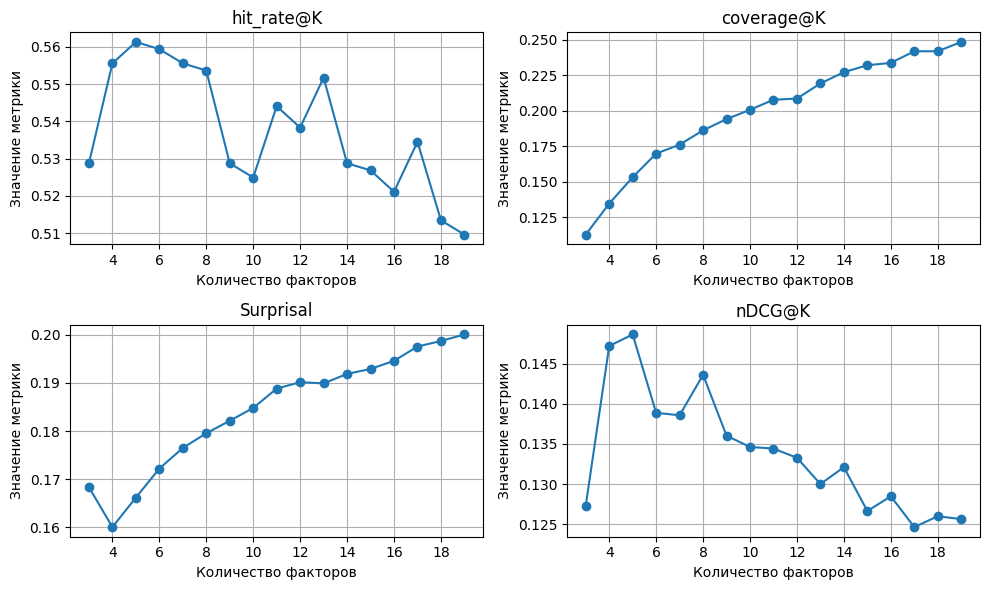

In [346]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()
for ax, (key, values) in zip(axes, metrics.items()):
    ax.plot(range(3, 20), values, marker='o')
    ax.set_xlabel("Количество факторов")
    ax.set_ylabel("Значение метрики")
    ax.set_title(key)
    ax.grid()
plt.tight_layout()
plt.show()

### ALS on positive

In [347]:
train_als = reviews[reviews["timestamp"] < pd.to_datetime("20001122")]
val_als = reviews[(reviews["timestamp"] >= pd.to_datetime("20001122")) & (reviews["timestamp"] < pd.to_datetime("20001201"))]
val_als = val_als[val_als['relevance'] > 3]
train_users_als = set(train_als["user_id"])
val_als = val_als[val_als["user_id"].isin(train_users_als)]
train_als['relevance'] = train_als['relevance'].astype(float)
train_positive = train_als[train_als['relevance'] > 3]
train_users_positive = set(train_positive["user_id"])
val_als = val_als[val_als["user_id"].isin(train_users_positive)]

user_item_matrix_positive, val_users_als, user_mapping_als, item_mapping_als, item_mapping_reverse_als = preproc(train_positive, val_als)

def optimizing(trial):
    factors = trial.suggest_int("factors", 5, 50)
    regularization = trial.suggest_float("regularization", 1e-6, 0.1, log=True)

    metrics = {'hit_rate@K': [], 'coverage@K': [], 'Surprisal': [], 'nDCG@K': []}
    model = AlternatingLeastSquares(factors=factors, regularization=regularization)
    model.fit(user_item_matrix_positive)
    recommendations = []
    for user in tqdm(val_users_als):
        user_idx = user_mapping_als[user]

        user_interactions = train_als[train_als['user_id'] == user]
        user_interactions = user_interactions[user_interactions['item_id'].isin(train_positive['item_id'])]
        seen_items = list(user_interactions['item_id'].map(item_mapping_reverse_als).values)

        recs = model.recommend(user_idx, user_item_matrix_positive[user_idx], N=20, filter_items=seen_items)

        for item_idx, relevance in zip(recs[0], recs[1]):
            recommendations.append((user, item_mapping_als[item_idx], relevance))
    recommendations = pd.DataFrame(recommendations, columns=['user_id', 'item_id', 'relevance'])
    metrics_res = measure(recommendations, val_als, train_positive, 20, 'ALS on positive')
    for i, key in enumerate(metrics.keys()):
        metrics[key].append(np.array(metrics_res)[0][i])
    return metrics['nDCG@K']

study = optuna.create_study(direction="maximize")
study.optimize(optimizing, n_trials=70, show_progress_bar=True)

<ipython-input-347-52113b51635a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_als['relevance'] = train_als['relevance'].astype(float)
[I 2025-03-24 21:01:54,638] A new study created in memory with name: no-name-ac490bfc-e8e6-4536-844a-52da5eaa2392


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 135.26it/s]


[I 2025-03-24 21:02:02,593] Trial 0 finished with value: 0.1523635334861094 and parameters: {'factors': 35, 'regularization': 1.61306925706749e-05}. Best is trial 0 with value: 0.1523635334861094.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 149.37it/s]


[I 2025-03-24 21:02:12,396] Trial 1 finished with value: 0.15108352790752247 and parameters: {'factors': 43, 'regularization': 4.289218897436893e-06}. Best is trial 0 with value: 0.1523635334861094.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 103.74it/s]


[I 2025-03-24 21:02:21,386] Trial 2 finished with value: 0.1690850292756789 and parameters: {'factors': 17, 'regularization': 1.2715563829648116e-05}. Best is trial 2 with value: 0.1690850292756789.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 153.64it/s]


[I 2025-03-24 21:02:28,633] Trial 3 finished with value: 0.15346469899726936 and parameters: {'factors': 33, 'regularization': 0.008488760362035804}. Best is trial 2 with value: 0.1690850292756789.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 123.81it/s]


[I 2025-03-24 21:02:35,742] Trial 4 finished with value: 0.16660866433853166 and parameters: {'factors': 15, 'regularization': 2.3930307556312154e-05}. Best is trial 2 with value: 0.1690850292756789.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 153.62it/s]


[I 2025-03-24 21:02:44,282] Trial 5 finished with value: 0.14864404822014504 and parameters: {'factors': 45, 'regularization': 5.005485782366148e-06}. Best is trial 2 with value: 0.1690850292756789.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 151.74it/s]


[I 2025-03-24 21:02:53,281] Trial 6 finished with value: 0.16962638340189232 and parameters: {'factors': 20, 'regularization': 0.00027335398756944305}. Best is trial 6 with value: 0.16962638340189232.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 151.77it/s]


[I 2025-03-24 21:03:02,960] Trial 7 finished with value: 0.1606240106333294 and parameters: {'factors': 25, 'regularization': 1.8843014931681806e-05}. Best is trial 6 with value: 0.16962638340189232.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 157.95it/s]


[I 2025-03-24 21:03:10,799] Trial 8 finished with value: 0.1727033933466474 and parameters: {'factors': 17, 'regularization': 0.02717099452604775}. Best is trial 8 with value: 0.1727033933466474.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 152.48it/s]


[I 2025-03-24 21:03:19,738] Trial 9 finished with value: 0.17095361229915362 and parameters: {'factors': 21, 'regularization': 0.013149859553286245}. Best is trial 8 with value: 0.1727033933466474.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 124.81it/s]


[I 2025-03-24 21:03:25,605] Trial 10 finished with value: 0.18496572862794894 and parameters: {'factors': 5, 'regularization': 0.08830437371114845}. Best is trial 10 with value: 0.18496572862794894.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 154.27it/s]


[I 2025-03-24 21:03:30,814] Trial 11 finished with value: 0.18356341738229764 and parameters: {'factors': 6, 'regularization': 0.047534925770456996}. Best is trial 10 with value: 0.18496572862794894.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 156.83it/s]


[I 2025-03-24 21:03:35,775] Trial 12 finished with value: 0.1790630663159444 and parameters: {'factors': 5, 'regularization': 0.08501546602923869}. Best is trial 10 with value: 0.18496572862794894.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 108.06it/s]


[I 2025-03-24 21:03:43,700] Trial 13 finished with value: 0.18233148764070084 and parameters: {'factors': 5, 'regularization': 0.0019185229894077695}. Best is trial 10 with value: 0.18496572862794894.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:05<00:00, 61.10it/s]


[I 2025-03-24 21:03:54,254] Trial 14 finished with value: 0.1712964739364256 and parameters: {'factors': 10, 'regularization': 0.001185574024238457}. Best is trial 10 with value: 0.18496572862794894.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:06<00:00, 57.12it/s]


[I 2025-03-24 21:04:06,448] Trial 15 finished with value: 0.16842156506281108 and parameters: {'factors': 11, 'regularization': 0.08350261447981398}. Best is trial 10 with value: 0.18496572862794894.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 152.99it/s]


[I 2025-03-24 21:04:12,077] Trial 16 finished with value: 0.16747383790581652 and parameters: {'factors': 11, 'regularization': 0.0001439401815147328}. Best is trial 10 with value: 0.18496572862794894.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 101.81it/s]


[I 2025-03-24 21:04:24,455] Trial 17 finished with value: 0.14481016947031256 and parameters: {'factors': 50, 'regularization': 0.0028414317638910448}. Best is trial 10 with value: 0.18496572862794894.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 144.40it/s]


[I 2025-03-24 21:04:35,635] Trial 18 finished with value: 0.1591384955702784 and parameters: {'factors': 29, 'regularization': 0.03061940391343979}. Best is trial 10 with value: 0.18496572862794894.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 106.78it/s]


[I 2025-03-24 21:04:42,494] Trial 19 finished with value: 0.18411458657029894 and parameters: {'factors': 5, 'regularization': 0.005643407764631547}. Best is trial 10 with value: 0.18496572862794894.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 137.36it/s]


[I 2025-03-24 21:04:49,650] Trial 20 finished with value: 0.16823600183107318 and parameters: {'factors': 10, 'regularization': 0.007069520409699383}. Best is trial 10 with value: 0.18496572862794894.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 128.86it/s]


[I 2025-03-24 21:04:55,809] Trial 21 finished with value: 0.18390615021003998 and parameters: {'factors': 6, 'regularization': 0.036252472493794465}. Best is trial 10 with value: 0.18496572862794894.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 121.76it/s]


[I 2025-03-24 21:05:03,689] Trial 22 finished with value: 0.1658330521996658 and parameters: {'factors': 13, 'regularization': 0.01978565842427548}. Best is trial 10 with value: 0.18496572862794894.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:07<00:00, 50.93it/s]


[I 2025-03-24 21:05:16,474] Trial 23 finished with value: 0.16932079550504084 and parameters: {'factors': 9, 'regularization': 0.004943903243282968}. Best is trial 10 with value: 0.18496572862794894.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 150.71it/s]


[I 2025-03-24 21:05:21,805] Trial 24 finished with value: 0.1822180287692199 and parameters: {'factors': 7, 'regularization': 0.07993007544259924}. Best is trial 10 with value: 0.18496572862794894.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 100.18it/s]


[I 2025-03-24 21:05:34,193] Trial 25 finished with value: 0.16903823640406648 and parameters: {'factors': 20, 'regularization': 0.00095521895143789}. Best is trial 10 with value: 0.18496572862794894.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 100.67it/s]


[I 2025-03-24 21:05:41,802] Trial 26 finished with value: 0.16637304427430116 and parameters: {'factors': 14, 'regularization': 0.015298699721792727}. Best is trial 10 with value: 0.18496572862794894.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:04<00:00, 82.07it/s]


[I 2025-03-24 21:05:49,036] Trial 27 finished with value: 0.1850256288967626 and parameters: {'factors': 5, 'regularization': 0.0006137401064147566}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 128.56it/s]


[I 2025-03-24 21:05:59,461] Trial 28 finished with value: 0.16544964520212213 and parameters: {'factors': 25, 'regularization': 6.501918090584572e-05}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 109.42it/s]


[I 2025-03-24 21:06:09,689] Trial 29 finished with value: 0.15301261521229073 and parameters: {'factors': 36, 'regularization': 1.0000246514883487e-06}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 138.24it/s]


[I 2025-03-24 21:06:15,405] Trial 30 finished with value: 0.17147285537033166 and parameters: {'factors': 8, 'regularization': 0.0005594836387908927}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:04<00:00, 83.00it/s]


[I 2025-03-24 21:06:23,852] Trial 31 finished with value: 0.18398872779287276 and parameters: {'factors': 5, 'regularization': 0.004559086308754583}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:04<00:00, 84.85it/s]


[I 2025-03-24 21:06:31,977] Trial 32 finished with value: 0.18274143574945942 and parameters: {'factors': 5, 'regularization': 0.0027851920350623898}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:04<00:00, 89.55it/s] 


[I 2025-03-24 21:06:40,644] Trial 33 finished with value: 0.17093431092230554 and parameters: {'factors': 13, 'regularization': 0.00035905312006188016}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 99.37it/s] 


[I 2025-03-24 21:06:47,345] Trial 34 finished with value: 0.16988809704360883 and parameters: {'factors': 8, 'regularization': 0.00010906149159222113}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 149.14it/s]


[I 2025-03-24 21:06:55,659] Trial 35 finished with value: 0.16835476050407894 and parameters: {'factors': 18, 'regularization': 0.005039793130371201}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:05<00:00, 70.39it/s]


[I 2025-03-24 21:07:08,499] Trial 36 finished with value: 0.15359506491109395 and parameters: {'factors': 38, 'regularization': 0.001025466100953765}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 99.74it/s]


[I 2025-03-24 21:07:17,661] Trial 37 finished with value: 0.16764772676489043 and parameters: {'factors': 15, 'regularization': 0.00921339761055346}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:04<00:00, 75.53it/s] 


[I 2025-03-24 21:07:28,130] Trial 38 finished with value: 0.1679317950594727 and parameters: {'factors': 11, 'regularization': 3.603889291334885e-05}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 146.40it/s]


[I 2025-03-24 21:07:33,649] Trial 39 finished with value: 0.17032471966954746 and parameters: {'factors': 8, 'regularization': 0.00022837570397758527}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 141.25it/s]


[I 2025-03-24 21:07:43,345] Trial 40 finished with value: 0.14919695039129127 and parameters: {'factors': 41, 'regularization': 0.0005378662173087886}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 148.09it/s]


[I 2025-03-24 21:07:48,577] Trial 41 finished with value: 0.18179480303336093 and parameters: {'factors': 5, 'regularization': 0.029253215271341823}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 124.18it/s]


[I 2025-03-24 21:07:55,143] Trial 42 finished with value: 0.18234993872711547 and parameters: {'factors': 7, 'regularization': 0.04351105456069566}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 146.72it/s]


[I 2025-03-24 21:08:01,081] Trial 43 finished with value: 0.16667199957768777 and parameters: {'factors': 12, 'regularization': 0.014845611719405443}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 109.81it/s]


[I 2025-03-24 21:08:07,691] Trial 44 finished with value: 0.1839274358341333 and parameters: {'factors': 7, 'regularization': 0.04528159874183894}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 144.01it/s]


[I 2025-03-24 21:08:13,297] Trial 45 finished with value: 0.1699722381183436 and parameters: {'factors': 8, 'regularization': 0.003417341204611791}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 108.15it/s]


[I 2025-03-24 21:08:21,115] Trial 46 finished with value: 0.1660212786070941 and parameters: {'factors': 16, 'regularization': 0.0015485954036598768}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 145.00it/s]


[I 2025-03-24 21:08:26,459] Trial 47 finished with value: 0.17713744949636206 and parameters: {'factors': 5, 'regularization': 0.054941979080792853}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 97.60it/s] 


[I 2025-03-24 21:08:33,444] Trial 48 finished with value: 0.16777293034839758 and parameters: {'factors': 10, 'regularization': 0.006407468189907414}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:04<00:00, 81.68it/s]


[I 2025-03-24 21:08:45,393] Trial 49 finished with value: 0.1549883851892449 and parameters: {'factors': 31, 'regularization': 0.010522009896743616}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 141.14it/s]


[I 2025-03-24 21:08:53,730] Trial 50 finished with value: 0.1726740481661311 and parameters: {'factors': 18, 'regularization': 0.02209087368024207}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 110.47it/s]


[I 2025-03-24 21:09:00,954] Trial 51 finished with value: 0.1835447115481937 and parameters: {'factors': 7, 'regularization': 0.05099562705407518}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 146.97it/s]


[I 2025-03-24 21:09:06,363] Trial 52 finished with value: 0.18472614694059572 and parameters: {'factors': 6, 'regularization': 0.03740631331197275}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 99.50it/s] 


[I 2025-03-24 21:09:13,217] Trial 53 finished with value: 0.1707338548454184 and parameters: {'factors': 9, 'regularization': 0.08250044094681643}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 147.73it/s]


[I 2025-03-24 21:09:18,536] Trial 54 finished with value: 0.18489606644582693 and parameters: {'factors': 5, 'regularization': 0.018503707083931533}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 105.31it/s]


[I 2025-03-24 21:09:25,062] Trial 55 finished with value: 0.18427863155217827 and parameters: {'factors': 5, 'regularization': 0.01564239069907821}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 120.81it/s]


[I 2025-03-24 21:09:31,371] Trial 56 finished with value: 0.1692108375202258 and parameters: {'factors': 10, 'regularization': 0.025959341137695737}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 94.15it/s] 


[I 2025-03-24 21:09:38,851] Trial 57 finished with value: 0.16952605302436985 and parameters: {'factors': 13, 'regularization': 0.015509966752146482}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 134.52it/s]


[I 2025-03-24 21:09:44,520] Trial 58 finished with value: 0.1834627078452338 and parameters: {'factors': 6, 'regularization': 0.010051571516343998}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 134.25it/s]


[I 2025-03-24 21:09:54,403] Trial 59 finished with value: 0.16671379612420634 and parameters: {'factors': 23, 'regularization': 0.09307823168734804}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 136.57it/s]


[I 2025-03-24 21:10:00,418] Trial 60 finished with value: 0.16714145270514266 and parameters: {'factors': 11, 'regularization': 1.103135151038214e-05}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 115.33it/s]


[I 2025-03-24 21:10:07,116] Trial 61 finished with value: 0.18042270411348496 and parameters: {'factors': 5, 'regularization': 0.004723957576173555}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 141.83it/s]


[I 2025-03-24 21:10:12,868] Trial 62 finished with value: 0.17452068284895841 and parameters: {'factors': 9, 'regularization': 0.0020341243337925795}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 98.60it/s] 


[I 2025-03-24 21:10:19,667] Trial 63 finished with value: 0.18401216409142584 and parameters: {'factors': 6, 'regularization': 0.021786943235885318}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 135.39it/s]


[I 2025-03-24 21:10:25,389] Trial 64 finished with value: 0.17234815607621254 and parameters: {'factors': 7, 'regularization': 0.06269627172459168}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:03<00:00, 93.76it/s] 


[I 2025-03-24 21:10:32,569] Trial 65 finished with value: 0.17253398052193827 and parameters: {'factors': 9, 'regularization': 0.02081524224247665}. Best is trial 27 with value: 0.1850256288967626.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 140.89it/s]


[I 2025-03-24 21:10:38,117] Trial 66 finished with value: 0.18553705761035677 and parameters: {'factors': 6, 'regularization': 0.03342938262471522}. Best is trial 66 with value: 0.18553705761035677.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:04<00:00, 87.59it/s] 


[I 2025-03-24 21:10:45,843] Trial 67 finished with value: 0.16729056396780337 and parameters: {'factors': 12, 'regularization': 0.032618793832169146}. Best is trial 66 with value: 0.18553705761035677.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 138.83it/s]


[I 2025-03-24 21:10:54,900] Trial 68 finished with value: 0.14563010847171462 and parameters: {'factors': 47, 'regularization': 0.01386731854456166}. Best is trial 66 with value: 0.18553705761035677.


  0%|          | 0/15 [00:00<?, ?it/s]


100%|██████████| 366/366 [00:02<00:00, 144.93it/s]


[I 2025-03-24 21:11:01,329] Trial 69 finished with value: 0.18424717867480345 and parameters: {'factors': 6, 'regularization': 0.06510454525327505}. Best is trial 66 with value: 0.18553705761035677.


In [348]:
study.best_params

{'factors': 6, 'regularization': 0.03342938262471522}

In [349]:
factors, regularization = study.best_params['factors'], study.best_params['regularization']

train_positive = train[train['relevance'] > 3]
train_users_positive = set(train_positive["user_id"])
val_positive = val[val["user_id"].isin(train_users_positive)]

user_item_matrix_positive, val_users_positive, user_mapping_positive, item_mapping_positive, item_mapping_reverse_positive = preproc(train_positive, val_positive)

metrics = {'hit_rate@K': [], 'coverage@K': [], 'Surprisal': [], 'nDCG@K': []}
model = AlternatingLeastSquares(factors=factors, regularization=regularization)
model.fit(user_item_matrix_positive)
recommendations = []
for user in tqdm(val_users_positive):
    user_idx = user_mapping_positive[user]

    user_interactions = train[train['user_id'] == user]
    user_interactions = user_interactions[user_interactions['item_id'].isin(train_positive['item_id'])]
    seen_items = list(user_interactions['item_id'].map(item_mapping_reverse_positive).values)

    recs = model.recommend(user_idx, user_item_matrix_positive[user_idx], N=20, filter_items=seen_items)

    for item_idx, relevance in zip(recs[0], recs[1]):
        recommendations.append((user, item_mapping_positive[item_idx], relevance))
recommendations = pd.DataFrame(recommendations, columns=['user_id', 'item_id', 'relevance'])
metrics_res = measure(recommendations, val_positive, train_positive, 20, 'TF-IDF on positive')
for i, key in enumerate(metrics.keys()):
    metrics[key].append(np.array(metrics_res)[0][i])

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 522/522 [00:03<00:00, 153.14it/s]


In [350]:
ALS_metrics = {'hit_rate@K' : metrics['hit_rate@K'][0],
               'coverage@K' : metrics['coverage@K'][0],
               'Surprisal' : metrics['Surprisal'][0],
               'nDCG@K' : metrics['nDCG@K'][0]}
rec_data.loc["ALS on positive"] = ALS_metrics
rec_data

,hit_rate@K,coverage@K,Surprisal,nDCG@K
Baseline,0.124521,0.931731,0.519658,0.00885
CosineRecommender,0.492337,0.086019,0.155762,0.134443
TF-IDF,0.509579,0.090661,0.152611,0.133444
TF-IDF on positive,0.754789,0.081376,0.178326,0.150679
ALS,0.549808,0.105953,0.149272,0.142041
ALS on positive,0.605364,0.142545,0.202067,0.163353


# Подготовьте выводы по всему ноутбуку
Какие модели работали лучше? Какие для этого могут быть причины? Какие из моделей наиболее чувствительны к настройке гиперпараметров? Расскажите об интересных наблюдениях и трудностях.

Посмотрим на распределение метрик.

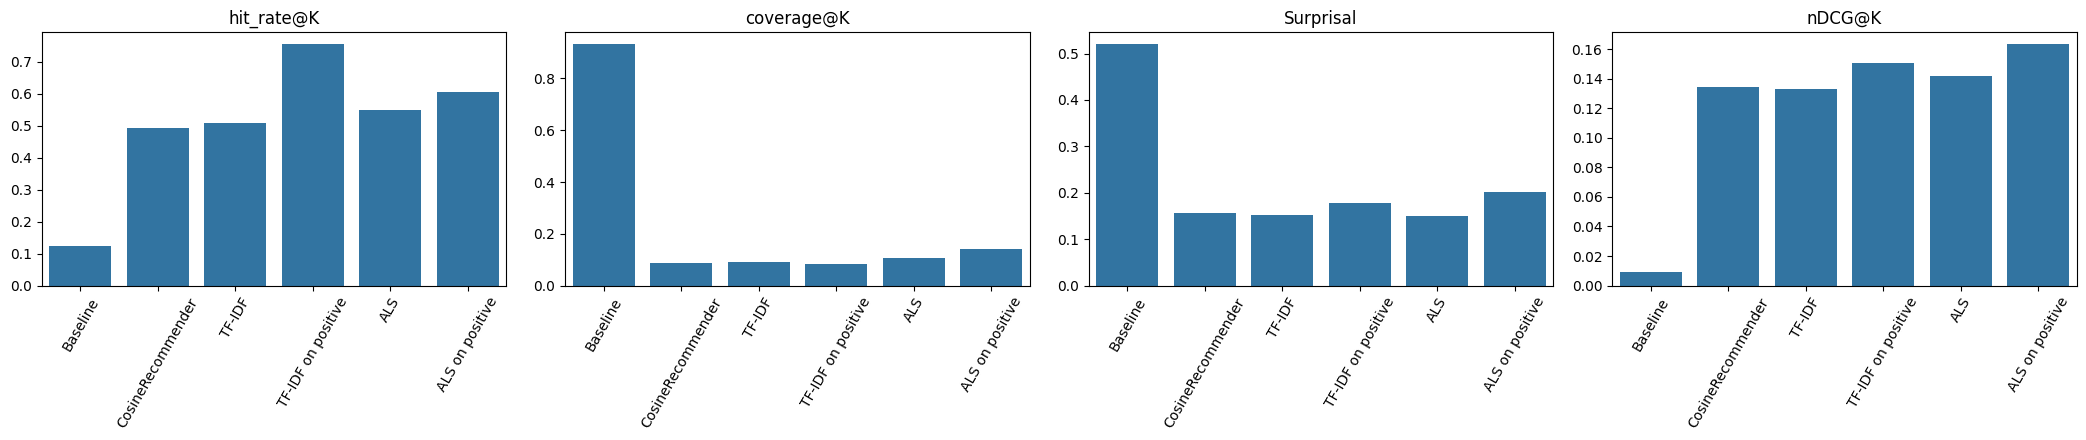

In [351]:
fig, axs = plt.subplots(ncols=4, figsize=(21, 4.5))

for ax, metrics in zip(axs.ravel(), rec_data.columns):
    sns.barplot(rec_data[metrics], ax=ax)
    ax.set_title(metrics)
    ax.set_ylabel("")
    ax.tick_params(axis='x', labelrotation=60)

plt.tight_layout()

ALS и TF-IDF справился на данном датасете лучше CosineRecommender. Они более теоретически обоснованный. При этом на позитивных рекомендациях они показали лучшее значение NDCG@K. Это вызвано тем, что NGCG@K работает без учета значения отзыва, а просто по факту его прибывания в выборках. Странно, что TF-IDF на позитивных значениях дает такое большое значение hit_rate@K. Возможно, сама логика метода подводит к этому, ведь мы более выборочно рекомендуем пользователям. А это тоже хорошо для некоторых постановок задачи. Очень странно, что ALS выдает всего 3 и 5 факторов. На графиках видно, что тем самым мы рекомендуем всем примерно одно и то же. Возможно стоит взять больше валидационную выборку и сделать более умный подбор параметров, который учитывает не только метрику NDCG@K. ALS оказался самым чувствительным к гиперпараметрам и при этом оочень долго обучается, валидация для него был очень времязатратный процесс. При этом он показал лучший результат и это радует, ожидание было не зря.

Самым трудным в задании была работа с разряженными матрицами, это забирало слишком много сил ;(.